In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Đánh giá mô hình
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve,
    confusion_matrix,
    classification_report
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV # tinh chỉnh
from scipy.stats import randint
from scipy.stats import loguniform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/DS102 - Machine Learning/Hotel/data/'

In [ ]:
def evaluations(y_true, y_pred, y_proba, model_name, dataset):

  print("="*50)
  print(f'Model {model_name}, đánh giá trên tập {dataset}:')
  print("Accuracy :", accuracy_score(y_true, y_pred))
  print("Precision:", precision_score(y_true, y_pred))
  print("Recall   :", recall_score(y_true, y_pred))
  print("F1-score :", f1_score(y_true, y_pred))
  print("ROC-AUC  :", roc_auc_score(y_true, y_proba))
  print("Confusion matrix:")
  print(confusion_matrix(y_true, y_pred))
  print(classification_report(y_true, y_pred))

In [ ]:
def plot_evaluations(y_true, y_pred, y_proba, model_name, dataset):

  fig, axes = plt.subplots(2,2, figsize=(15,8))
  axes = axes.flatten()

  # confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
  axes[0].set_title(f'Confusion Matrix - {model_name}, {dataset}')
  axes[0].set_xlabel('Predicted')
  axes[0].set_ylabel('Actual')

  # precision - recall curve
  precision, recall, threshold = precision_recall_curve(y_true, y_proba)
  average_precison = average_precision_score(y_true, y_proba)
  axes[1].plot(recall, precision, linewidth=2, zorder=3)
  axes[1].set_title(f'Precision-Recall Curve - {model_name}, {dataset}\nAverage precision score: {average_precison:.4f}')
  axes[1].set_xlabel('Recall cho lớp Hủy')
  axes[1].set_ylabel('Precision cho lớp Hủy')
  axes[1].grid(True, alpha=0.5, zorder=0)

  # threshold - recall
  thesholds = np.linspace(0,1,100)
  recalls = [
      recall_score(y_true, (y_proba > threshold).astype(int))
      for threshold in thesholds
  ]
  axes[2].plot(thesholds, recalls, linewidth=2, zorder=3)
  axes[2].set_title(f'Threshold - Recall - {model_name}, {dataset}')
  axes[2].set_xlabel('Threshold')
  axes[2].set_ylabel('Recall cho lớp Hủy')
  axes[2].grid(True, alpha=0.5, zorder=0)

  # roc curve
  fpr, tpr, thresholds = roc_curve(y_true, y_proba)
  auc = roc_auc_score(y_true, y_proba)

  axes[3].plot(fpr, tpr, linewidth=2, zorder=3)
  axes[3].plot([0,1], [0,1], 'k--', zorder=1)
  axes[3].set_title(f'ROC Curve - {model_name}, {dataset}\nAUC: {auc:.4f}')
  axes[3].grid(True, alpha=0.5, zorder=0)
  axes[3].set_xlabel('False Positive Rate')
  axes[3].set_ylabel('True Positive Rate')

  plt.tight_layout()
  plt.show()

# Dữ liệu

In [ ]:
X_train = pd.read_csv(DATA_PATH + 'X_train.csv')
X_dev = pd.read_csv(DATA_PATH + 'X_dev.csv')
X_test = pd.read_csv(DATA_PATH + 'X_test.csv')

y_train = pd.read_csv(DATA_PATH + 'y_train.csv')
y_dev = pd.read_csv(DATA_PATH + 'y_dev.csv')
y_test = pd.read_csv(DATA_PATH + 'y_test.csv')

# Biến đổi và mã hóa dữ liệu

In [ ]:
log_cols = ['lead_time']
ohe_cols = ['market_segment', 'distribution_channel',
            'assigned_room_type', 'customer_type', 'hotel_type',
            'country_group']
ordinal_cols = [
    'previous_cancellations_group',
    'previous_bookings_not_canceled_group',
    'booking_changes_group',
    'days_in_waiting_list_group',
    'deposit_type'
]

ordinal_categories = [
    ['0', '1-5', '>5'],                 # previous_cancellations_group
    ['0', '1-5', '>5'],                 # previous_bookings_not_canceled_group
    ['0', '1-2', '>2'],                 # booking_changes_group
    ['no_wait', 'short', 'medium', 'long', 'very_long'],
    ['No Deposit', 'Refundable', 'Non Refund'] # không đặt cọc, có hoàn tiền , ko hoàn tiền
]

In [ ]:
class LogTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return np.log1p(X)

  def get_feature_names_out(self, input_features=None):
    return np.array([f'log_{feature}' for feature in input_features])


ohe_transformer = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse_output=False
)

ord_transformer = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log', LogTransformer(), log_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('ord', ord_transformer, ordinal_cols)
    ],
    remainder='passthrough'
)

In [ ]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('log', LogTransformer(), ['lead_time']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['market_segment', 'distribution_channel',
                                  'assigned_room_type', 'customer_type',
                                  'hotel_type', 'country_group']),
                                ('ord',
                                 OrdinalEncoder(categories=[['0', '1-5', '>5'],
                                                            ['0', '1-5', '>5'],
                                                            ['0', '1-2', '>2'],
                                                            ['no_wait', 'short',
                                                             'medium', 'long',
                                                             'very_long'],
                                                            ['No Deposit',
                                                             'Refundable',
                                                             'Non Refund']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['previous_cancellations_group',
                                  'previous_bookings_not_canceled_group',
                                  'booking_changes_group',
                                  'days_in_waiting_list_group',
                                  'deposit_type'])])

# Mô hình Random Forest

## Huấn luyện

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=300,
                                     max_depth=None,
                                     max_features='sqrt',
                                     min_samples_leaf=5,
                                     bootstrap=True,
                                     random_state=42, n_jobs=-1))
])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log', LogTransformer(),
                                                  ['lead_time']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['market_segment',
                                                   'distribution_channel',
                                                   'assigned_room_type',
                                                   'customer_type',
                                                   'hotel_type',
                                                   'country_group']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[[...
                                                                              'very_long'],
                                                                             ['No '
                                                                              'Deposit',
                                                                              'Refundable',
                                                                              'Non '
                                                                              'Refund']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['previous_cancellations_group',
                                                   'previous_bookings_not_canceled_group',
                                                   'booking_changes_group',
                                                   'days_in_waiting_list_group',
                                                   'deposit_type'])])),
                ('model',
                 RandomForestClassifier(min_samples_leaf=5, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

Dự đoán trên train

In [ ]:
y_pred = pipeline.predict(X_train)
y_proba = pipeline.predict_proba(X_train)[:,1]

In [ ]:
evaluations(y_train, y_pred, y_proba, 'Random Forest', 'train')

Model Random Forest, đánh giá trên tập train:
Accuracy : 0.8691140384075399
Precision: 0.8660727542687454
Recall   : 0.7663655772704878
F1-score : 0.8131741744358282
ROC-AUC  : 0.9492508426143056
Confusion matrix:
[[47858  3608]
 [ 7113 23332]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     51466
           1       0.87      0.77      0.81     30445

    accuracy                           0.87     81911
   macro avg       0.87      0.85      0.86     81911
weighted avg       0.87      0.87      0.87     81911



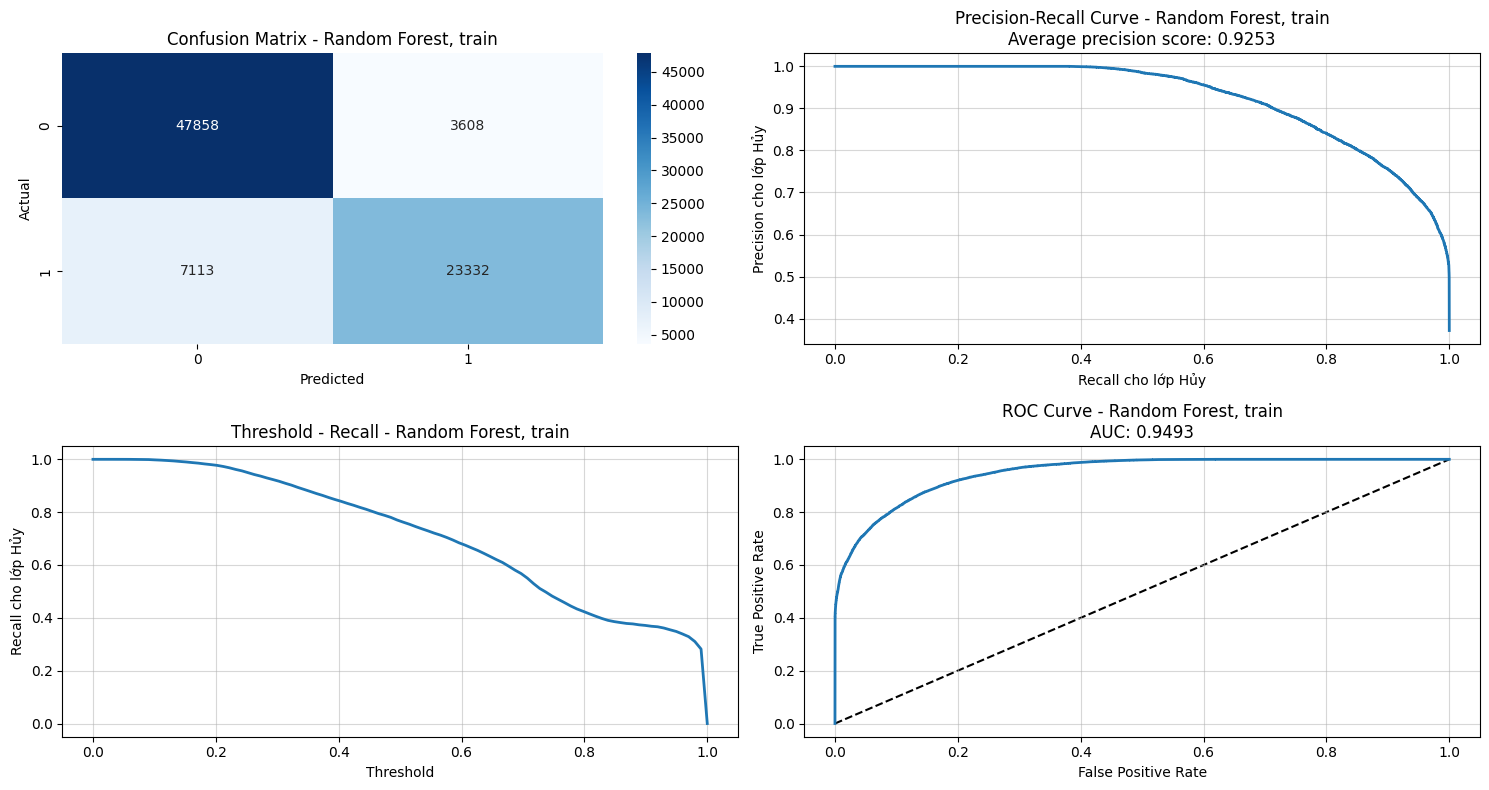

In [ ]:
plot_evaluations(y_train, y_pred, y_proba, 'Random Forest', 'train')

## Đánh giá trên dev

### Trước khi tinh chỉnh

In [ ]:
y_dev_pred = pipeline.predict(X_dev)
y_dev_proba = pipeline.predict_proba(X_dev)[:,1]

In [ ]:
evaluations(y_dev, y_dev_pred, y_dev_proba, 'Random Forest', 'dev')

Model Random Forest, đánh giá trên tập dev:
Accuracy : 0.857232381929015
Precision: 0.8546964193046186
Recall   : 0.7478431966096565
F1-score : 0.7977074588311269
ROC-AUC  : 0.9343095144259927
Confusion matrix:
[[10106   840]
 [ 1666  4941]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     10946
           1       0.85      0.75      0.80      6607

    accuracy                           0.86     17553
   macro avg       0.86      0.84      0.84     17553
weighted avg       0.86      0.86      0.86     17553



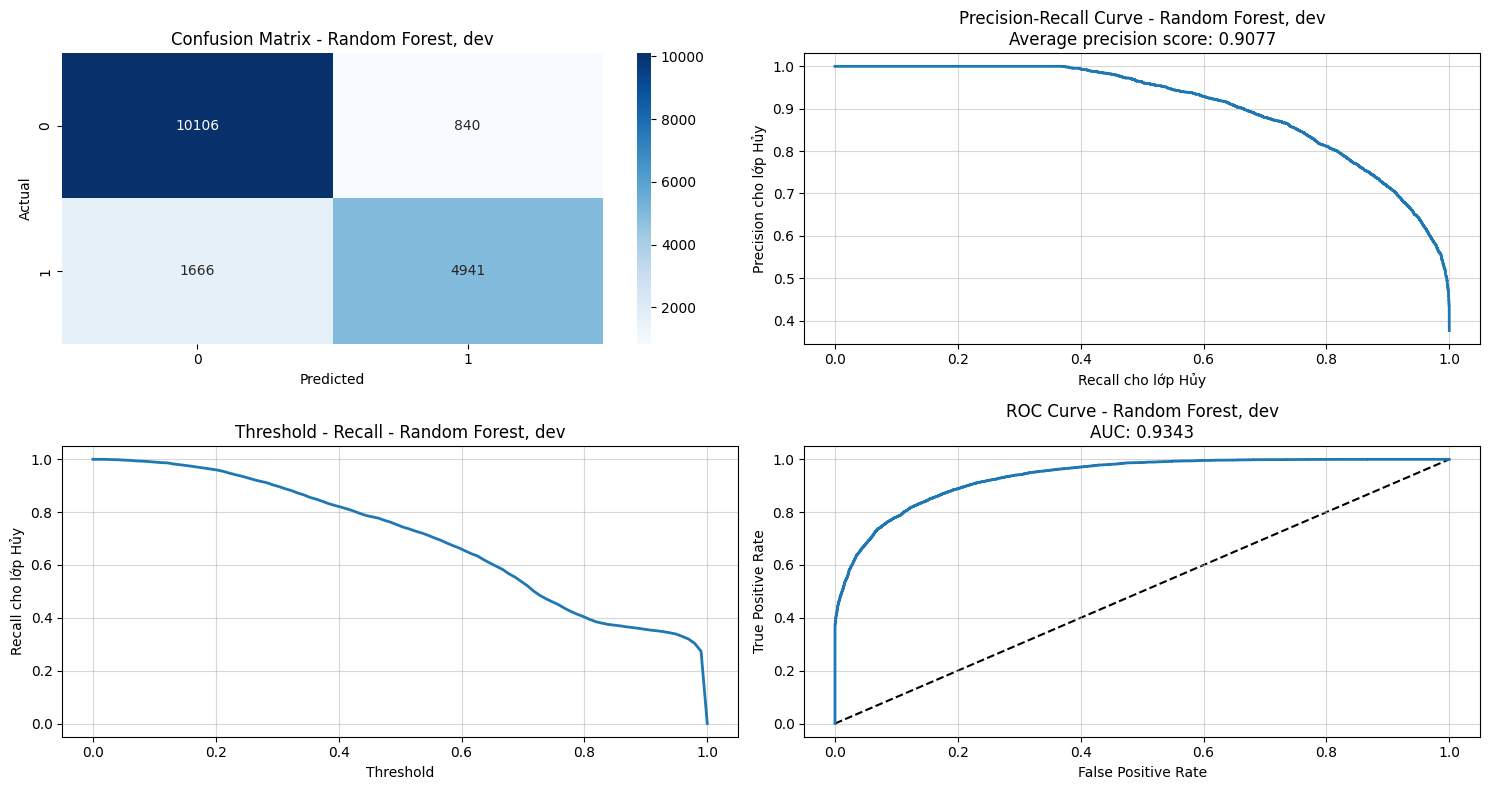

In [ ]:
plot_evaluations(y_dev, y_dev_pred, y_dev_proba, 'Random Forest', 'dev')

Nhận xét:
- Mô hình có độ chính xác cao, với số lượng TP và TN lớn. Đặc biệt, số lượng FN thấp hơn so với Logistic Regression, cho thấy Random Forest ít bỏ sót các trường hợp Huỷ hơn.

- Precision và Recall đều rất tốt, cao hơn so với Logistic Regression. Điều này cho thấy Random Forest có khả năng phân biệt lớp Huỷ hiệu quả hơn.

- Mô hình phản ứng tốt với việc điều chỉnh ngưỡng, cho phép tối ưu hóa theo mục tiêu cụ thể (tăng phát hiện Huỷ thì giảm ngưỡng).

- AUC rất cao, vượt Logistic Regression, cho thấy Random Forest có khả năng phân biệt hai lớp mạnh mẽ hơn.

Mô hình Random Forest hoạt động rất tốt trên tập phát triển, vượt trội hơn Logistic Regression ở cả Precision, Recall và AUC, F1-score.

### Tinh chỉnh

In [ ]:
param_dist_rf = {
    'model__n_estimators': randint(100, 300),      # số cây
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['sqrt', 'log2'],
    'model__class_weight': [None, 'balanced']
}

In [ ]:
random_search_rf = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

random_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               LogTransformer(),
                                                                               ['lead_time']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['market_segment',
                                                                                'distribution_channel',
                                                                                'assigned_room_type',
                                                                                'customer_type',
                                                                                'hotel_type',
                                                                                'country_group']),
                                                                              (...
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c3ff9bcd280>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c3ff9804800>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c3ffa6c7680>},
                   scoring='f1', verbose=1)

### Sau khi tinh chỉnh

In [ ]:
y_dev_pred = random_search_rf.predict(X_dev)
y_dev_proba = random_search_rf.predict_proba(X_dev)[:,1]

In [ ]:
random_search_rf.best_params_

{'model__class_weight': 'balanced',
 'model__max_depth': 30,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 10,
 'model__n_estimators': 122}

In [ ]:
random_search_rf.best_score_

np.float64(0.8078681366861936)

In [ ]:
best_pipe = random_search_rf.best_estimator_
rf = best_pipe.named_steps['model']

In [ ]:
feature_importances = rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

In [ ]:
evaluations(y_dev, y_dev_pred, y_dev_proba, 'Random Forest', 'dev')

Model Random Forest, đánh giá trên tập dev:
Accuracy : 0.8573463225659431
Precision: 0.7996202716518183
Recall   : 0.8286665657635841
F1-score : 0.8138843466627026
ROC-AUC  : 0.9377973770600427
Confusion matrix:
[[9574 1372]
 [1132 5475]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     10946
           1       0.80      0.83      0.81      6607

    accuracy                           0.86     17553
   macro avg       0.85      0.85      0.85     17553
weighted avg       0.86      0.86      0.86     17553



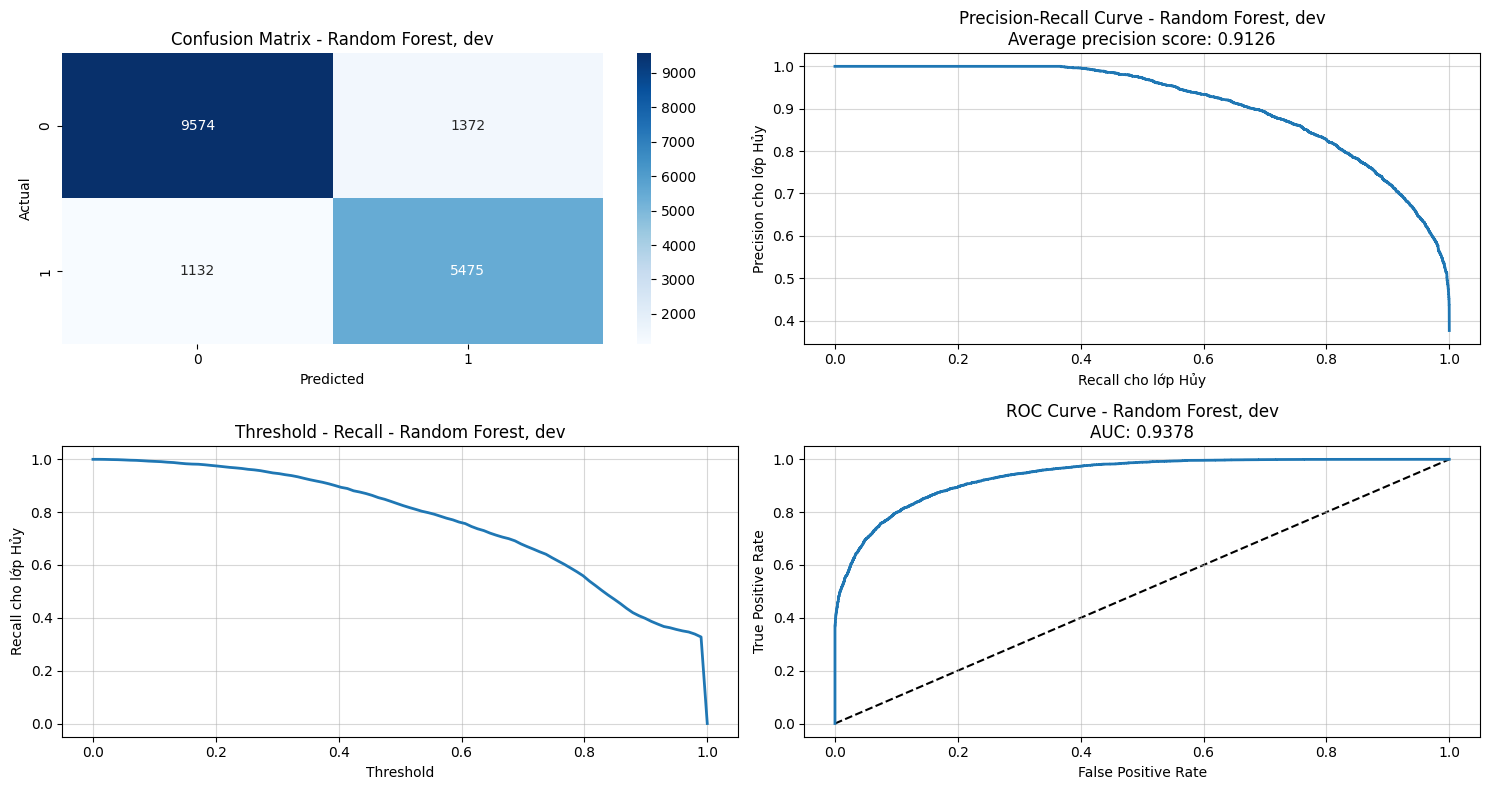

In [ ]:
plot_evaluations(y_dev, y_dev_pred, y_dev_proba, 'Random Forest', 'dev')

Tinh chỉnh đã giúp mô hình phát hiện lớp Huỷ tốt hơn (TP tăng, FN giảm), rất quan trọng với mục tiêu là giảm rủi ro bỏ sót.

Precision-Recall và AUC đều tăng, cho thấy mô hình không chỉ chính xác hơn mà còn phân biệt hai lớp rõ ràng hơn.

FP tăng nhẹ, tức là mô hình có xu hướng cảnh báo sớm hơn, có thể chấp nhận được với mục tiêu là phát hiện tối đa các trường hợp Huỷ.

## Giải thích mô hình

### Feature Importance

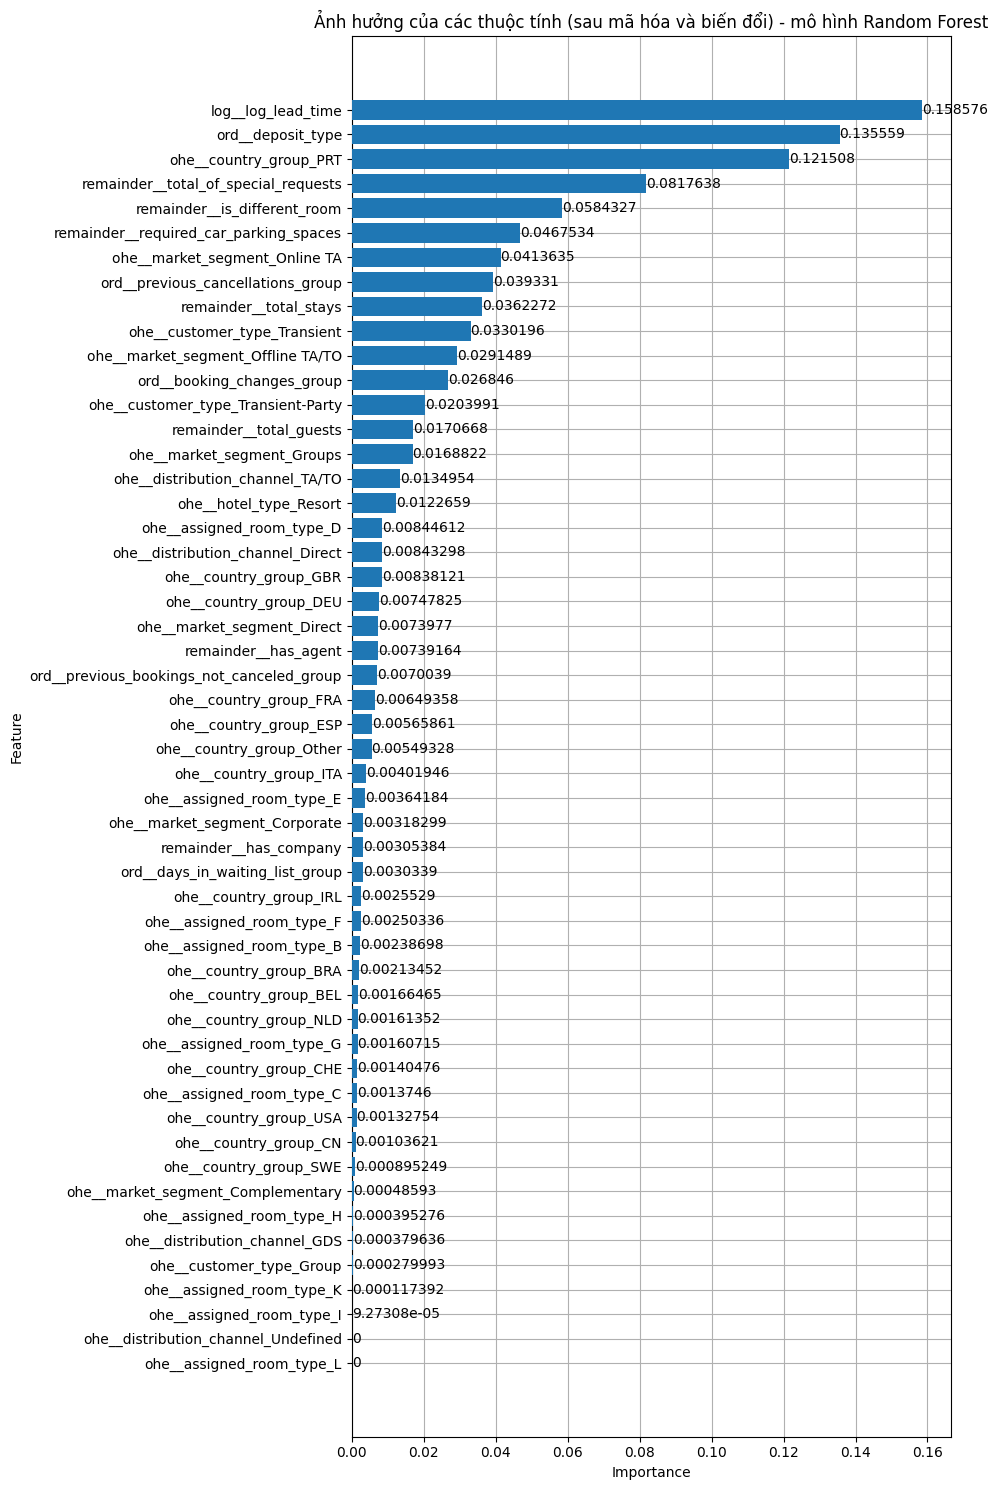

In [ ]:
plt.figure(figsize=(10, 15))

plt.barh(
    feature_importance_df['feature'],
    feature_importance_df['importance'],
    zorder=3
)

plt.bar_label(plt.gca().containers[0])
plt.gca().invert_yaxis()

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Ảnh hưởng của các thuộc tính (sau mã hóa và biến đổi) - mô hình Random Forest")

plt.grid(True, zorder=0)
plt.tight_layout()
plt.show()

Mỗi thuộc tính được đánh giá dựa trên mức độ giảm impurity (gini) khi được sử dụng để chia nhánh trong cây.

Giá trị càng cao -> thuộc tính càng quan trọng trong việc phân loại chính xác.

Các thuộc tính quan trọng:
* log_log_lead_time
* ord_deposit_type
* ohe_country_group_PRT
* remainder_total_of_special_requests
* remainder_is_different_room

- Các thuộc tính như deposit_type, country_group_PRT, lead_time, và special_requests đều được xác nhận là quan trọng bởi cả Logistic Regression và Random Forest, nên được giữ lại và phân tích sâu hơn.

- Một số thuộc tính như previous_cancellations_group có Odds Ratio rất cao nhưng SHAP và RF lại thấp → có thể là do tính chất tuyến tính của Logistic Regression phóng đại ảnh hưởng.

### SHAP

In [ ]:
import shap

In [ ]:
X_dev_trans = preprocessor.transform(X_dev)

np.random.seed(42)

idx = np.random.choice(
    X_dev_trans.shape[0],
    size=300,
    replace=False      # không lặp
)

X_shap = X_dev_trans[idx]

explainer = shap.TreeExplainer(
    rf,
    approximate=True,
    feature_names=feature_names
)

shap_values = explainer(X_shap)

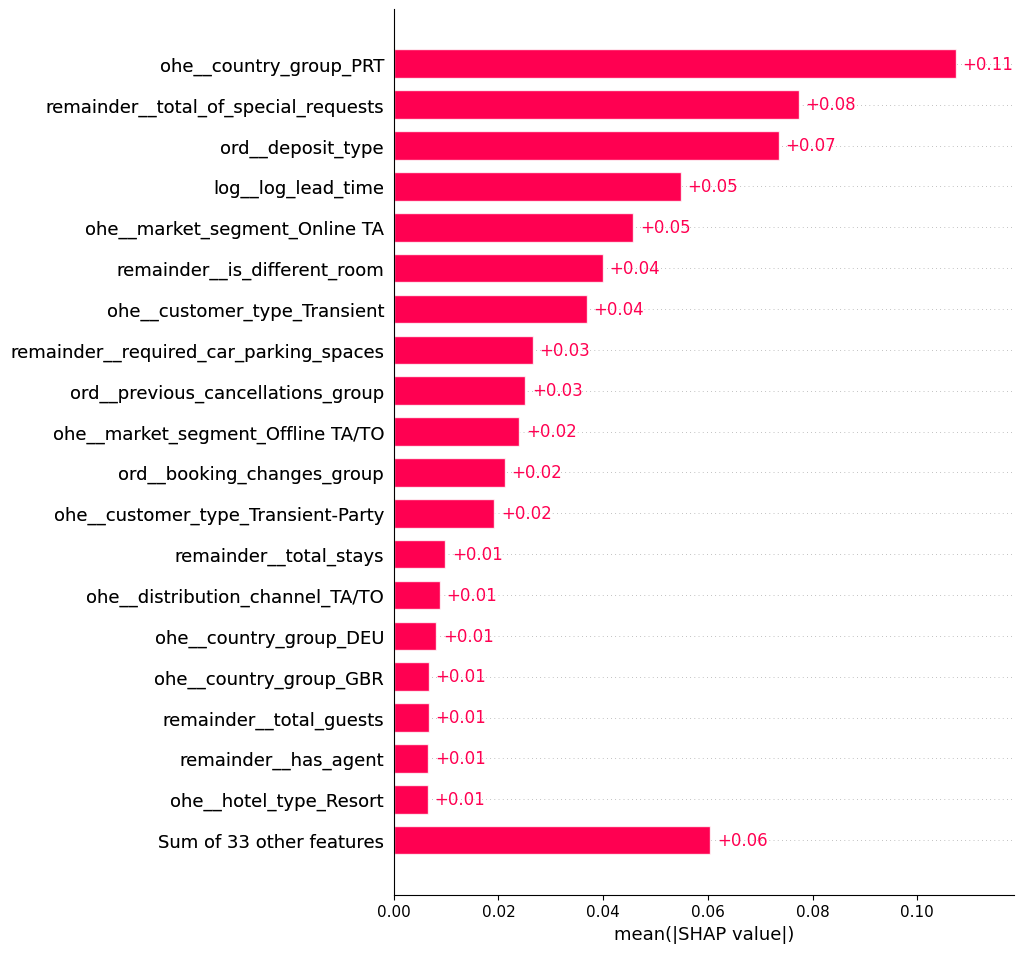

In [ ]:
shap.plots.bar(
    shap_values[:, :, 1],
    max_display=20
)

Các thuộc tính như PRT, deposit_type, lead_time, và special_requests đều được xác nhận là quan trọng nên rất đáng tin cậy để dùng trong phân tích nghiệp vụ.

#### Đánh giá trên 1 sample đầu tiên của dev

In [ ]:
shap_values[1][0]

.values =
array([ 0.04091697, -0.04091697])

.base_values =
array([0.50016116, 0.49983884])

.data =
np.float64(2.5649493574615367)

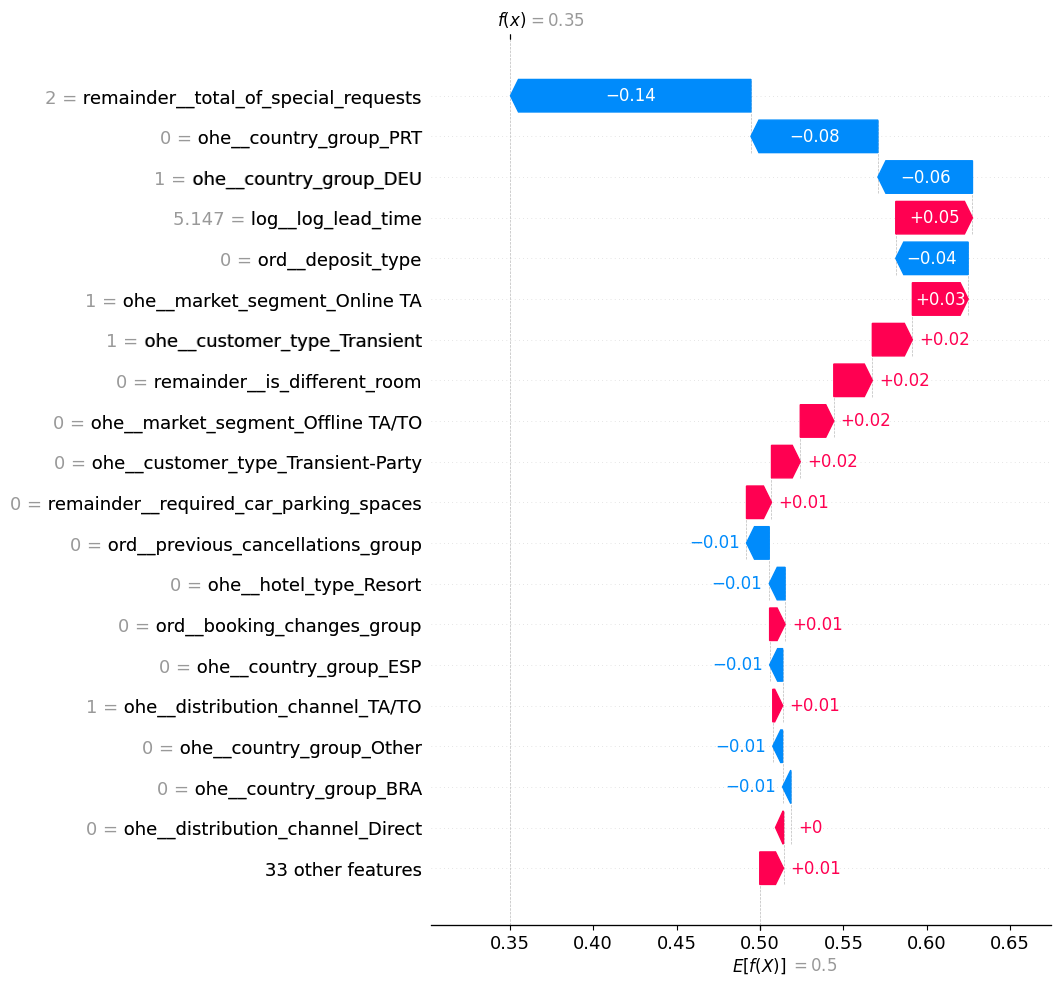

In [ ]:
shap.plots.waterfall(
    shap_values[0, :, 1],   # sample 0, tất cả feature, class 1
    max_display=20
)

Mô hình dự đoán xác suất xảy ra sự kiện thấp hơn trung bình, chủ yếu nhờ các yếu tố như có đặt cọc, nhiều yêu cầu đặc biệt, và không có lịch sử huỷ.

# Lưu mô hình

In [ ]:
import joblib

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/DS102 - Machine Learning/Hotel/models/'

joblib.dump(rf, MODEL_PATH + 'model_randomforest.pkl')

['/content/drive/MyDrive/DS102 - Machine Learning/Hotel/models/model_randomforest.pkl']